In [24]:
import essentia.standard as ess
import librosa as lib
import numpy as np
import matplotlib.pyplot as plt
import HTKPython as HTK
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from essentia import Pool
from scipy import pi
import   scipy.io as sp

In [25]:
########### extract filterbank with htk
URImfcFile = 'HTK/vignesh.mfc_no_preemph'

HTKFeat_reader =  HTK.htk_open(URImfcFile, 'rb')
htkMFCC = HTKFeat_reader.getall()
htkMFCC = htkMFCC.T
htkMFCC =htkMFCC[[-1,0,1,2,3,4,5,6,7,8,9,10,11],:]

fs = 44100
audio = ess.MonoLoader(filename = 'audio/vignesh.wav', 
                                      sampleRate = fs)()
# dynamic range expansion as done in Matlab HTK implementation
audio = audio*2**15
matlabMFCC= sp.loadmat('matlab/MFCCs.mat')['MFCCs']
#matlabMFCC = matlabMFCC[[-1,0,1,2,3,4,5,6,7,8,9,10,11],:]

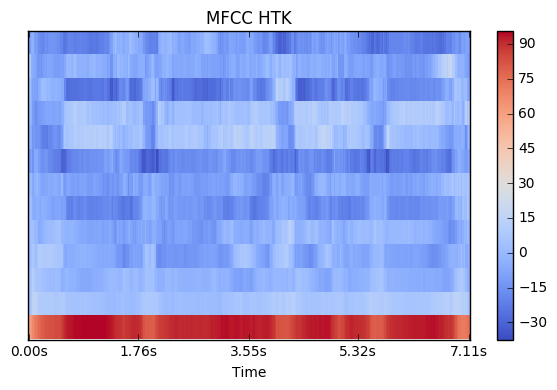

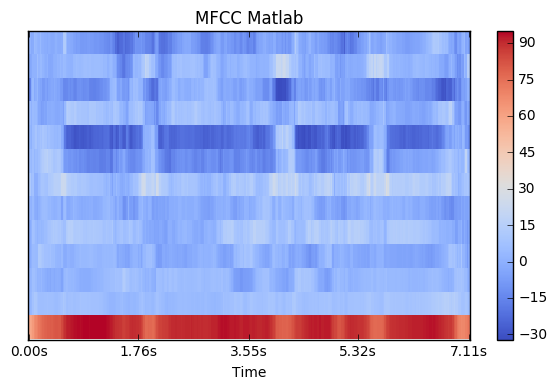

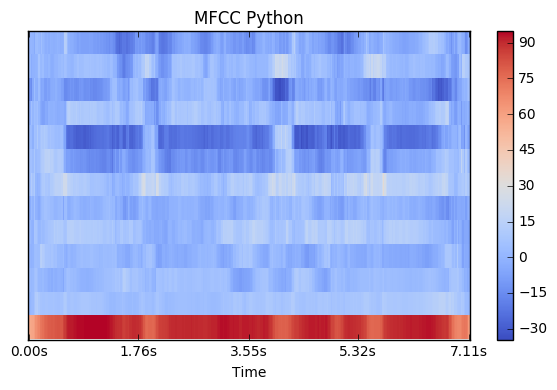

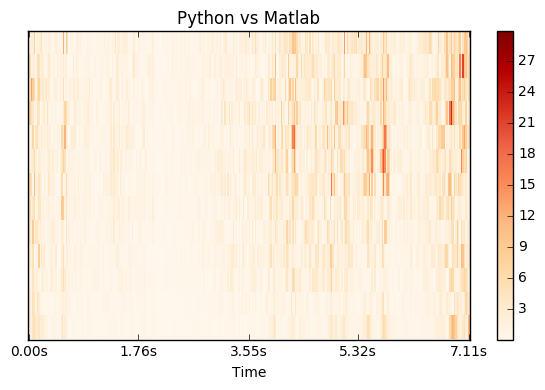

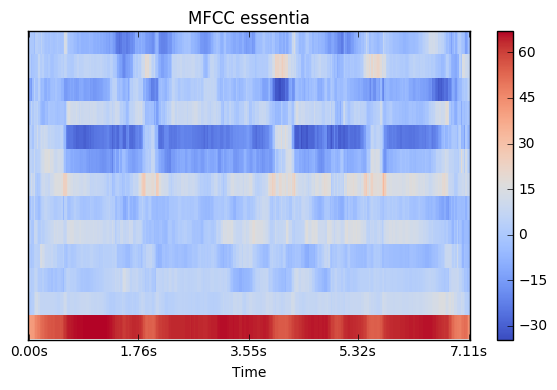

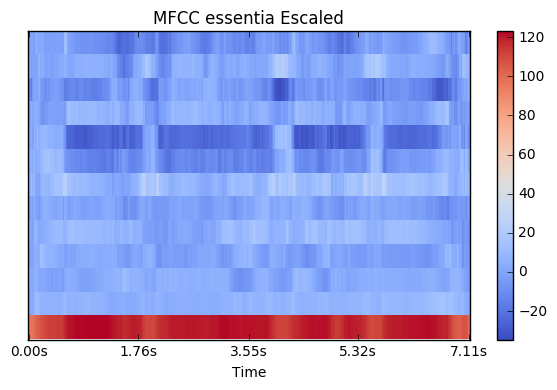

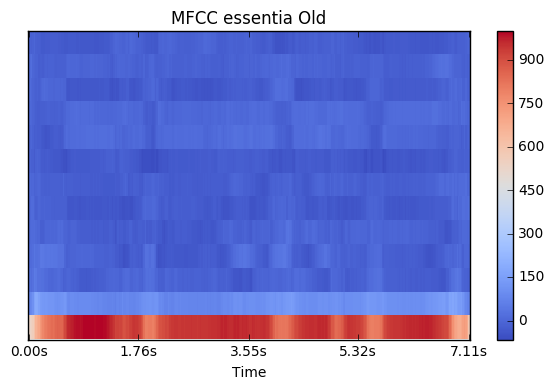

In [35]:
frameSize = 1104
hopSize = 447
spectrumSize= 2048
zeroPadding = spectrumSize - frameSize

w = ess.Windowing(type = 'hamming', 
                    size = spectrumSize, 
                    zeroPadding = zeroPadding,
                    normalized = False,
                    zeroPhase = False)

melsEssentia = ess.MelBands(inputSize = spectrumSize,
                    type = 'magnitude', 
                    warpingFormula = 'htkMel',
                    weighting = 'linear',
                    highFrequencyBound = 8000,
                    lowFrequencyBound = 300,
                    numberBands = 26,
                    normalize = 'unit_max',)

mfccEssentia = ess.MFCC(inputSize = spectrumSize,
                    type = 'magnitude', 
                    warpingFormula = 'htkMel',
                    weighting = 'linear',
                    highFrequencyBound = 8000,
                    lowFrequencyBound = 300,
                    numberBands = 26,
                    numberCoefficients = 13,
                    normalize = 'unit_max',
                    dctType = 3,
                    logType = 'log',
                    liftering = 22)

mfccEssentiaOld = ess.MFCC(inputSize = spectrumSize,
                    highFrequencyBound = 8000,
                    numberBands = 26,
                    numberCoefficients = 13)


spectrum = ess.Spectrum(size = fftSize)
pool = Pool()

for frame in ess.FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize):
    spect = spectrum(w(frame))
    pool.add('MFCC',mfccEssentia(spect)[1])
    pool.add('MFCCEscaled',mfccEssentia(spect*60662)[1])
    pool.add('MFCCOld',mfccEssentiaOld(spect)[1])
    pool.add('MelBands',melsEssentia(spect))
    
    
essentiaMFCC = np.array(pool['MFCC'].T);
essentiaMFCCOld = np.array(pool['MFCCOld'].T);
essentiaMFCCEscaled = np.array(pool['MFCCEscaled'].T);
essentiaMelBands = np.array(pool['MelBands'].T);

# Processing imitating Matlab
coefficients = 13
bands = 26

# DCT bassis HTK formula, slighly different to librosa implementation
basis1 = np.ones((coefficients, bands))
librosaMFCC = np.zeros([13,307])
liftering = 22

for i in range(0, coefficients):
    for j in range (0, bands):
        basis1[i, j] = np.sqrt(2.0/bands) * np.cos((pi/bands)*(i)* (j+0.5)) 
librosaMFCC =np.dot(basis1, np.log(essentiaMelBands))       

#Liftering
for i in range(len(librosaMFCC.T)):
    librosaMFCC[:,i] = ( 1 + 0.5*liftering*np.sin(pi*(np.arange(coefficients))/liftering) ) * librosaMFCC[:,i]

# Ploting HTK
lib.display.specshow(htkMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC HTK')
plt.tight_layout()
plt.show()

#Ploting Matlab
lib.display.specshow(matlabMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Matlab')
plt.tight_layout()
plt.show()

# Librosa
lib.display.specshow(librosaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Python')
plt.tight_layout()
plt.show()

# Python vs Matlab
lib.display.specshow(np.abs( librosaMFCC - matlabMFCC), x_axis='time')
plt.colorbar()
plt.title('Python vs Matlab')
plt.tight_layout()
plt.show()

#Ploting essentia
lib.display.specshow(essentiaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC essentia')
plt.tight_layout()
plt.show()


#Ploting essentia
lib.display.specshow(essentiaMFCCEscaled, x_axis='time')
plt.colorbar()
plt.title('MFCC essentia Escaled')
plt.tight_layout()
plt.show()



lib.display.specshow(essentiaMFCCOld, x_axis='time')
plt.colorbar()
plt.title('MFCC essentia Old')
plt.tight_layout()
plt.show()